<a href="https://colab.research.google.com/github/mengwangk/FortuneNet/blob/master/fortunenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FortuneNet

## Magic

In [49]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

## Imports

In [50]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import featuretools as ft
import matplotlib as mpl
import matplotlib.pyplot as plt

In [51]:
from fastai.basics import *
from fastai.tabular import *

## Setup

In [52]:
# to make this notebook's output stable across runs
np.random.seed(42)

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

In [53]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
ID = "fortunenet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Helper Functions

In [54]:
def add_datepart(df, fldname, drop=True, time=False):
    """Helper function that adds columns relevant to a date."""
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [55]:
def download_file(url, path, download_path):
    """Download the dataset"""
    if not os.path.isdir(path):
        os.makedirs(path)
    urllib.request.urlretrieve(url, download_path)
    if (os.path.isfile(download_path)):
        print(f'Download path: {download_path}')

## Datasets - Run the section you want to analyse

In [56]:
import os
import zipfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://www.sportstoto.com.my/"
LOTTO_PATH = os.path.join(os.getcwd(), "datasets", "lotto")

### Dataset - 4D

In [57]:
_4D_URL = DOWNLOAD_ROOT + "upload/4D.zip"
_4D_ZIP = os.path.join(LOTTO_PATH, "4D.zip")

In [58]:
# Download 4D
download_file(_4D_URL, LOTTO_PATH, _4D_ZIP)

Download path: /Users/mengwangk/workspace/development/FortuneNet/datasets/lotto/4D.zip


In [59]:
downloaded_file = _4D_ZIP

### Dataset - Others

## Read the downloaded file

In [198]:
# Read into data frame
df = pd.read_csv(downloaded_file, header=0, sep=',', quotechar='"')

In [199]:
# Tail the last 10 rows
df.tail(10)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10
4524,493219,20190410,1002,7403,123,4950,1195,524,6065,2364,8959,5930,989,8223,1889,8534,471,999,2114,5833,6200,8957,1097,4668,7028
4525,493319,20190413,9397,1660,2187,9181,2838,4971,400,9201,4830,8293,2589,2962,6365,8,1401,7610,6501,2624,4544,4911,7295,3974,8741
4526,493419,20190414,3196,3443,1796,1957,7325,6801,2098,2517,2231,8870,1121,9679,7159,8711,4940,4441,6414,4897,5403,9498,3661,9290,1809
4527,493519,20190417,4007,8246,1493,2102,194,6853,9083,6763,2599,5192,3514,8253,8548,2385,3325,6311,1837,8312,8840,8743,5015,335,5203
4528,493619,20190420,6622,7203,4982,993,7631,8813,6902,8474,4372,5081,2037,8326,6705,5764,5979,1951,7761,9182,8027,5130,8119,2508,5710
4529,493719,20190421,3634,5822,4752,7700,1287,2736,5179,4386,997,312,918,4313,6232,6400,2898,352,3326,6903,3435,3716,5085,4527,2554
4530,493819,20190424,1615,9328,6138,6914,4874,6988,2663,3020,1152,7209,527,3310,1081,6585,4517,1314,1181,9444,6827,1871,6984,7105,9314
4531,493919,20190427,3582,1486,8937,8464,5668,4914,2182,2689,7176,3315,3413,4247,9621,955,4440,8582,6238,2945,2016,2240,1286,8726,715
4532,494019,20190428,8975,1998,8973,3112,2316,8050,4631,3584,9329,1714,1572,5405,1344,5392,1206,7955,1235,1197,4883,6971,7918,155,6495
4533,494119,20190501,4633,4154,318,1271,7440,8707,6127,2690,8531,9627,6547,2222,2106,3663,8503,9387,4279,992,6246,9262,3764,4649,8866


## Preprocessing

### Transpose the data

In [200]:
df_transposed = df.melt(id_vars=["DrawNo", "DrawDate"], var_name="PrizeType", value_name="LuckyNo")
df_transposed = df_transposed.sort_values(["DrawNo", "DrawDate", "PrizeType"], ascending=True)
df_transposed['DrawDate'] = pd.to_datetime(df_transposed['DrawDate'], format='%Y%m%d')
df_transposed.reset_index(inplace=True, drop=True)
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104282 entries, 0 to 104281
Data columns (total 4 columns):
DrawNo       104282 non-null int64
DrawDate     104282 non-null datetime64[ns]
PrizeType    104282 non-null object
LuckyNo      104282 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [201]:
# Tail the data
df_transposed.head(23)

,DrawNo,DrawDate,PrizeType,LuckyNo
0,40792,1992-05-06,1stPrizeNo,19
1,40792,1992-05-06,2ndPrizeNo,1124
2,40792,1992-05-06,3rdPrizeNo,592
3,40792,1992-05-06,ConsolationNo1,5311
4,40792,1992-05-06,ConsolationNo10,407
5,40792,1992-05-06,ConsolationNo2,1949
6,40792,1992-05-06,ConsolationNo3,1606
7,40792,1992-05-06,ConsolationNo4,3775
8,40792,1992-05-06,ConsolationNo5,6226
9,40792,1992-05-06,ConsolationNo6,1271


In [202]:
# Split the date into year, month, day, day of week
# df_transformed["DrawYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).year
# df_transformed["DrawMonth"] = pd.DatetimeIndex(df_transformed["DrawDate"]).month
# df_transformed["DrawDay"] = pd.DatetimeIndex(df_transformed["DrawDate"]).day
# df_transformed["DrawDayOfYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).dayofyear
# df_transformed["DrawDayOfWeek"] = pd.DatetimeIndex(df_transformed["DrawDate"]).dayofweek
# df_transformed["DrawWeekDay"] = pd.DatetimeIndex(df_transformed["DrawDate"]).weekday
# df_transformed["DrawWeekOfYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).weekofyear
# df_transformed["DrawQuarter"] = pd.DatetimeIndex(df_transformed["DrawDate"]).quarter
df_processed = df_transposed.copy()
add_datepart(df_processed, 'DrawDate', drop=False)
df_processed.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
0,40792,1992-05-06,1stPrizeNo,19,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
1,40792,1992-05-06,2ndPrizeNo,1124,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
2,40792,1992-05-06,3rdPrizeNo,592,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
3,40792,1992-05-06,ConsolationNo1,5311,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
4,40792,1992-05-06,ConsolationNo10,407,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
5,40792,1992-05-06,ConsolationNo2,1949,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
6,40792,1992-05-06,ConsolationNo3,1606,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
7,40792,1992-05-06,ConsolationNo4,3775,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
8,40792,1992-05-06,ConsolationNo5,6226,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
9,40792,1992-05-06,ConsolationNo6,1271,1992,5,19,6,2,127,False,False,False,False,False,False,705110400


### Field Variables

In [203]:
# Outcome to predict
dep_var = "LuckyNo"

### Train and Validation Split

In [204]:
n = len(df_processed); n

104282

In [205]:
from sklearn.model_selection import train_test_split

X = df_processed.copy()
y = X[dep_var]; 
print(len(X))
print(len(y))

104282
104282


In [206]:
X.drop([dep_var], inplace=True, axis=1)
X.head(1)

,DrawNo,DrawDate,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
0,40792,1992-05-06,1stPrizeNo,1992,5,19,6,2,127,False,False,False,False,False,False,705110400


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [208]:
print(len(X_train)); print(len(X_test)); print(len(y_train)); print(len(y_test))

72997
31285
72997
31285


### Assignment

In [209]:
train_df = df_processed

## Experiment with a sample

In [210]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104282 entries, 0 to 104281
Data columns (total 17 columns):
DrawNo                  104282 non-null int64
DrawDate                104282 non-null datetime64[ns]
PrizeType               104282 non-null object
LuckyNo                 104282 non-null int64
DrawYear                104282 non-null int64
DrawMonth               104282 non-null int64
DrawWeek                104282 non-null int64
DrawDay                 104282 non-null int64
DrawDayofweek           104282 non-null int64
DrawDayofyear           104282 non-null int64
DrawIs_month_end        104282 non-null bool
DrawIs_month_start      104282 non-null bool
DrawIs_quarter_end      104282 non-null bool
DrawIs_quarter_start    104282 non-null bool
DrawIs_year_end         104282 non-null bool
DrawIs_year_start       104282 non-null bool
DrawElapsed             104282 non-null int64
dtypes: bool(6), datetime64[ns](1), int64(9), object(1)
memory usage: 9.3+ MB


In [211]:
idx = np.random.permutation(range(n))[:6000]
print(n)
print(len(idx))

idx.sort()
print(idx)

small_train_df = train_df.iloc[idx[:3000]]
small_test_df = train_df.iloc[idx[3000:]]

104282
6000
[     9     12     13     17 ... 104256 104265 104270 104277]


In [212]:
# Set continuous and categorical columns
small_cont_vars = ["DrawNo", "DrawElapsed"]
small_cat_vars = ["PrizeType", "DrawYear", "DrawMonth", "DrawWeek", "DrawDay", "DrawDayofweek", 
                  "DrawDayofyear","DrawIs_month_end","DrawIs_month_start", "DrawIs_quarter_end", "DrawIs_quarter_start", "DrawIs_year_end", "DrawIs_year_start"]

In [213]:
small_train_df = small_train_df[small_cat_vars + small_cont_vars + [dep_var]]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + [dep_var]]

In [214]:
small_train_df.head(5)

,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawNo,DrawElapsed,LuckyNo
9,ConsolationNo6,1992,5,19,6,2,127,False,False,False,False,False,False,40792,705110400,1271
12,ConsolationNo9,1992,5,19,6,2,127,False,False,False,False,False,False,40792,705110400,9258
13,SpecialNo1,1992,5,19,6,2,127,False,False,False,False,False,False,40792,705110400,950
17,SpecialNo4,1992,5,19,6,2,127,False,False,False,False,False,False,40792,705110400,3114
47,2ndPrizeNo,1992,5,19,10,6,131,False,False,False,False,False,False,40992,705456000,5766


In [215]:
small_test_df.head(5)

,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawNo,DrawElapsed,LuckyNo
51686,ConsolationNo2,2006,4,14,8,5,98,False,False,False,False,False,False,265506,1144454400,9945
51690,ConsolationNo6,2006,4,14,8,5,98,False,False,False,False,False,False,265506,1144454400,2813
51697,SpecialNo3,2006,4,14,8,5,98,False,False,False,False,False,False,265506,1144454400,341
51714,ConsolationNo7,2006,4,14,9,6,99,False,False,False,False,False,False,265606,1144540800,1462
51780,ConsolationNo4,2006,4,15,16,6,106,False,False,False,False,False,False,265906,1145145600,2889


In [216]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [217]:
small_train_df.PrizeType.cat.categories

Index(['1stPrizeNo', '2ndPrizeNo', '3rdPrizeNo', 'ConsolationNo1',
       'ConsolationNo10', 'ConsolationNo2', 'ConsolationNo3', 'ConsolationNo4',
       'ConsolationNo5', 'ConsolationNo6', 'ConsolationNo7', 'ConsolationNo8',
       'ConsolationNo9', 'SpecialNo1', 'SpecialNo10', 'SpecialNo2',
       'SpecialNo3', 'SpecialNo4', 'SpecialNo5', 'SpecialNo6', 'SpecialNo7',
       'SpecialNo8', 'SpecialNo9'],
      dtype='object')

In [218]:
small_train_df.PrizeType.cat.codes[:10]

9      9
12    12
13    13
17    17
47     1
50     4
57    11
60    14
81    12
85    16
dtype: int8

In [219]:
small_train_df.PrizeType.head(10)

9      ConsolationNo6
12     ConsolationNo9
13         SpecialNo1
17         SpecialNo4
47         2ndPrizeNo
50    ConsolationNo10
57     ConsolationNo8
60        SpecialNo10
81     ConsolationNo9
85         SpecialNo3
Name: PrizeType, dtype: category
Categories (23, object): [1stPrizeNo < 2ndPrizeNo < 3rdPrizeNo < ConsolationNo1 ... SpecialNo6 < SpecialNo7 < SpecialNo8 < SpecialNo9]

In [220]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [221]:
doc(FillMissing)

class FillMissing [source] FillMissing ( `cat_names` : StrList , `cont_names` : StrList , `fill_strategy` : FillStrategy = ` ` , `add_col` : bool = `True` , `fill_val` : float = `0.0` ) :: TabularProc 
 
 Fill the missing values in continuous columns. 
 Show in docs

In [222]:
import inspect
Categorify??

Init signature: Categorify(cat_names: Collection[str], cont_names: Collection[str]) -> None
Source:        
class Categorify(TabularProc):
    "Transform the categorical variables to that type."
    def apply_train(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical."
        self.categories = {}
        for n in self.cat_names:
            df.loc[:,n] = df.loc[:,n].astype('category').cat.as_ordered()
            self.categories[n] = df[n].cat.categories

    def apply_test(self, df:DataFrame):
        "Transform `self.cat_names` columns in categorical using the codes decided in `apply_train`."
        for n in self.cat_names:
            df.loc[:,n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)
File:           ~/anaconda3/lib/python3.7/site-packages/fastai/tabular/transform.py
Type:           type
Subclasses:     


In [223]:
small_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 9 to 51682
Data columns (total 16 columns):
PrizeType               3000 non-null category
DrawYear                3000 non-null category
DrawMonth               3000 non-null category
DrawWeek                3000 non-null category
DrawDay                 3000 non-null category
DrawDayofweek           3000 non-null category
DrawDayofyear           3000 non-null category
DrawIs_month_end        3000 non-null category
DrawIs_month_start      3000 non-null category
DrawIs_quarter_end      3000 non-null category
DrawIs_quarter_start    3000 non-null category
DrawIs_year_end         3000 non-null category
DrawIs_year_start       3000 non-null category
DrawNo                  3000 non-null int64
DrawElapsed             3000 non-null int64
LuckyNo                 3000 non-null int64
dtypes: category(13), int64(3)
memory usage: 154.7 KB


## Preparing full data set

In [224]:
n = len(df_processed)
print(n)
print(n/23)
print(df_processed['DrawDate'].min())
print(df_processed['DrawDate'].max())

split_percent = 0.8
idx = n * split_percent
print(idx)
idx = int(idx // 23 * 23)
print(idx)

train_df = df_processed[:idx]
test_df = df_processed[idx:]
print(len(train_df))
print(len(test_df))
print(len(train_df) + len(test_df))

104282
4534.0
1992-05-06 00:00:00
2019-05-01 00:00:00
83425.6
83421
83421
20861
104282


In [225]:
train_df.head(2)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
0,40792,1992-05-06,1stPrizeNo,19,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
1,40792,1992-05-06,2ndPrizeNo,1124,1992,5,19,6,2,127,False,False,False,False,False,False,705110400


In [226]:
test_df.head(1)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
83421,403514,2014-03-25,1stPrizeNo,1161,2014,3,13,25,1,84,False,False,False,False,False,False,1395705600


In [227]:
# Data normalization proceses
procs=[FillMissing, Categorify, Normalize]

In [228]:
# Set continuous and categorical columns
cont_vars = ["DrawNo", "DrawElapsed"]
cat_vars = ["PrizeType", "DrawYear", "DrawMonth", "DrawWeek", "DrawDay", "DrawDayofweek", 
                  "DrawDayofyear","DrawIs_month_end","DrawIs_month_start", "DrawIs_quarter_end", "DrawIs_quarter_start", "DrawIs_year_end", "DrawIs_year_start"]

In [229]:
dep_var = 'LuckyNo'

In [230]:
df = train_df[cat_vars + cont_vars + [dep_var,'DrawDate']].copy()
df.head(1)

,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawNo,DrawElapsed,LuckyNo,DrawDate
0,1stPrizeNo,1992,5,19,6,2,127,False,False,False,False,False,False,40792,705110400,19,1992-05-06


In [231]:
# Min and max draw date
test_df['DrawDate'].min(), test_df['DrawDate'].max()

(Timestamp('2014-03-25 00:00:00'), Timestamp('2019-05-01 00:00:00'))

### Create a validation set

In [234]:
# 1st criteria - of the same date
# 2nd criteria - >= len(test_df)

cut = train_df['DrawDate'][(train_df['DrawDate'] == train_df['DrawDate'][len(test_df)])].index.max()
print(cut)

20883


In [235]:
valid_idx = range(cut)
print(valid_idx)

range(0, 20883)


In [236]:
df[dep_var].head()

0      19
1    1124
2     592
3    5311
4     407
Name: LuckyNo, dtype: int64

## Train

In [237]:
path = Path('datasets/lotto')

In [243]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())
FloatList?
CategoryList?

Init signature:
CategoryList(
    ['items: Iterator', 'classes: Collection = None', 'label_delim: str = None', '**kwargs'],
)
Docstring:      Basic `ItemList` for single classification labels.
File:           ~/anaconda3/lib/python3.7/site-packages/fastai/data_block.py
Type:           type
Subclasses:     


### Model

In [239]:
max_log_y = np.log(np.max(train_df[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [240]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [241]:
doc(tabular_learner)

tabular_learner [source] tabular_learner ( `data` : DataBunch , `layers` : Collection [ int ], `emb_szs` : Dict [ str , int ]= `None` , `metrics` = `None` , `ps` : Collection [ float ]= `None` , `emb_drop` : float = `0.0` , `y_range` : OptRange = `None` , `use_bn` : bool = `True` , `kwargs` ) 
 
 Get a Learner using data , with metrics , including a TabularModel created using the remaining params. 
 Show in docs

In [244]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 9)
    (1): Embedding(18, 8)
    (2): Embedding(13, 7)
    (3): Embedding(54, 15)
    (4): Embedding(32, 11)
    (5): Embedding(6, 4)
    (6): Embedding(367, 44)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [247]:
len(data.train_ds.cont_names)

2

In [248]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


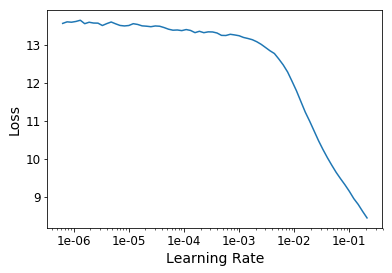

In [249]:
learn.recorder.plot()

In [250]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,inf,nan,nan
2,inf,nan,nan
3,inf,nan,nan
4,inf,nan,nan
5,inf,nan,nan
